<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S2_mobilenet_v2_custom_dataset/EVA4_S2_mobilnet_v2_transfer_learning_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading Libraries

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# 2. Load Data & Set Data Loaders
We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [2]:
!wget -q "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
!unzip -o -qq hymenoptera_data.zip

In [17]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

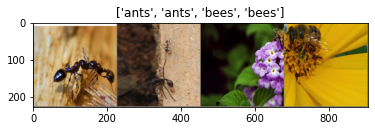

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title[:4])
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:4,:,:,:])

imshow(out, title=[class_names[x] for x in classes[0:4]])

# 4. Training the model
Now, let’s write a general function to train a model. Here, we will illustrate:

Scheduling the learning rate
Saving the best model
In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [32]:
 def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)                

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# 5. Visualizing the model predictions
Generic function to display predictions for a few images

In [33]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#6. Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


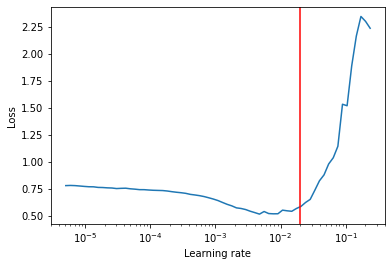

In [39]:
import torch.optim as optim
from torch_lr_finder import LRFinder

model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[1] = nn.Linear(1280, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ft.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.02) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [40]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.02, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs
                                          pct_start=0.20, 
                                          epochs=25,
                                          anneal_strategy='linear',
                                          base_momentum=0.8)

# 7. Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [41]:
model_res = train_model(model_ft, criterion, optimizer_ft, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6771 Acc: 0.5615
val Loss: 0.4680 Acc: 0.8105

Epoch 1/24
----------
train Loss: 0.3966 Acc: 0.8566
val Loss: 0.2933 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.2804 Acc: 0.9057
val Loss: 0.1976 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.1845 Acc: 0.9426
val Loss: 0.1793 Acc: 0.9608

Epoch 4/24
----------
train Loss: 0.1706 Acc: 0.9303
val Loss: 0.1832 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.1298 Acc: 0.9672
val Loss: 0.1541 Acc: 0.9608

Epoch 6/24
----------
train Loss: 0.1027 Acc: 0.9754
val Loss: 0.1601 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.1186 Acc: 0.9590
val Loss: 0.1716 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.1110 Acc: 0.9549
val Loss: 0.2595 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.1054 Acc: 0.9631
val Loss: 0.2201 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.1015 Acc: 0.9713
val Loss: 0.2135 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.1250 Acc: 0.9549
val Loss: 0.1858 Acc: 0.9346

Epoch 12/24
----------
t

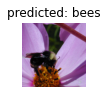

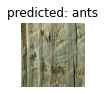

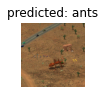

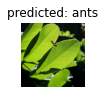

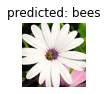

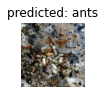

In [42]:
visualize_model(model_res)

# 8. ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


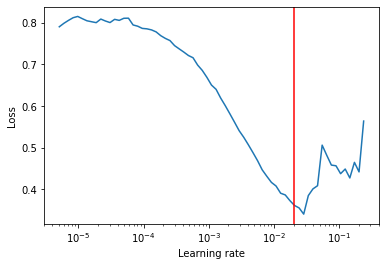

In [44]:
model_conv = model_ft
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_conv.classifier[1] = nn.Linear(1280, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_conv.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.02) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [45]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier[1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_conv,
                                          max_lr=0.02, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs
                                          pct_start=0.20, 
                                          epochs=25,
                                          anneal_strategy='linear',
                                          base_momentum=0.8)

In [46]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5939 Acc: 0.6680
val Loss: 0.2132 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.2299 Acc: 0.9016
val Loss: 0.2056 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.3506 Acc: 0.8934
val Loss: 0.2997 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.1742 Acc: 0.9467
val Loss: 0.2689 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.2117 Acc: 0.9426
val Loss: 0.2804 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.2718 Acc: 0.9057
val Loss: 0.7933 Acc: 0.8366

Epoch 6/24
----------
train Loss: 1.2306 Acc: 0.7705
val Loss: 0.3197 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.5605 Acc: 0.8525
val Loss: 0.4275 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.1980 Acc: 0.9549
val Loss: 0.4940 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.1536 Acc: 0.9590
val Loss: 0.4358 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3999 Acc: 0.9262
val Loss: 0.3535 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3738 Acc: 0.9057
val Loss: 0.3848 Acc: 0.9412

Ep

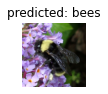

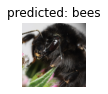

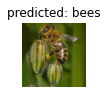

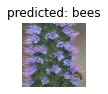

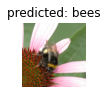

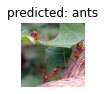

In [47]:
visualize_model(model_conv)

plt.ioff()
plt.show()